# 2018/2019 - Task List 1

1. Generate random variable from prefered dystribution using Pyro (pyro.sample)
    
    - animate how distribution of values changes
    - animate histograms of values
    - start with empty list of values, generate new samples, generate histogram
    
    
2. Write a simulator (and exact solution utilizing Bayes theorem) for chances to be ill on a certain disease. We know that it affects from about 1 to 100 out of 50,000 people. There was developed a test to check whether the person has the disease and it is quite accurate: the probability that the test result is positive (suggesting the person has the disease), given that the person does not have the disease, is only 2 percent; the probability that the test result is negative (suggesting the person does not have the disease), given that the person has the disease, is only 1 percent. When a random person gets tested for the disease and the result comes back positive, what is the probability that the person has the disease? Check whole parameter space and visualise results.

    - it must be a simulator!
    - sample from distribution using given probabilities
    - repeate experiment and compare with Bayes equation


## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Generating single value from normal distribution with given mean and variance

In [8]:
mean = 0
variance = 10
x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
print(x)

tensor(-13.7720)


## Sampling from categorical probabilities with given probabilities

In [145]:
x = pyro.sample("categorical_sampling", pyro.distributions.Categorical(logits = torch.tensor([0.01,1.4, 0.3,0.1, 0.5])))
print(x)

tensor(3)


## Animating data

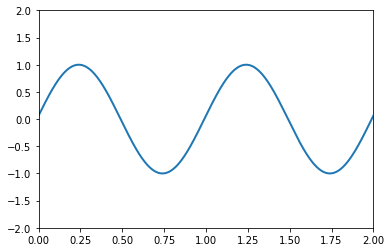

In [18]:
def animate():
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( 0, 2))
    ax.set_ylim((-2, 2))

    line, = ax.plot([], [], lw=2)
    
    # animation function. This is called sequentially
    def sin(i):
        x = np.linspace(0, 2, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x, y)
        return (line,)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, sin, init_func=init,
                                   frames=100, interval=20, blit=True)
    return HTML(anim.to_jshtml())

animate()

## Drawing histogram

Text(0,0.5,'Probability')

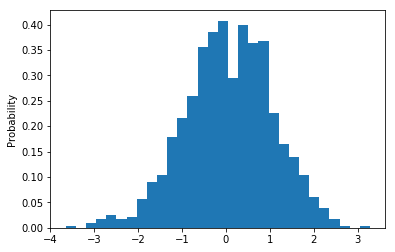

In [159]:
x = np.random.normal(size=1000)
fig, ax = plt.subplots()
ax.hist(x, density=True, bins=30)
plt.ylabel('Probability')

## Task 1

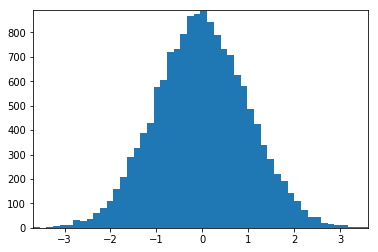

In [163]:
MEAN=0
VARIANCE=1
BINS=50
n_per_frame = 50

def gen_val(mean, variance):
    return pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))

def histo(ax, sample, i):
    if i == 0:
        return ax.hist(sample)
    ax.clear()
    n, bins, patches = ax.hist(sample, bins=BINS)
    ax.set_ylim((0, max(n)+1))
    ax.set_xlim((min(bins), max(bins)))
    
def histo_anim():
    fig, ax = plt.subplots()
    sample = []

    def runner(i):
        if i != 0:
            xs = [gen_val(MEAN, VARIANCE) for _ in range(n_per_frame)]
            sample.extend(xs)
        return histo(ax, sample, i)

    ani = animation.FuncAnimation(fig, runner, frames=300, interval=50)
    return HTML(ani.to_jshtml())

histo_anim()

## Task 2
2. Write a simulator (and exact solution utilizing Bayes theorem) for chances to be ill on a certain disease. We know that it affects from about 1 to 100 out of 50,000 people. There was developed a test to check whether the person has the disease and it is quite accurate: the probability that the test result is positive (suggesting the person has the disease), given that the person does not have the disease, is only 2 percent; the probability that the test result is negative (suggesting the person does not have the disease), given that the person has the disease, is only 1 percent. When a random person gets tested for the disease and the result comes back positive, what is the probability that the person has the disease? Check whole parameter space and visualise results.

    - it must be a simulator!
    - sample from distribution using given probabilities
    - repeate experiment and compare with Bayes equation

**A** - ill

**B** - not ill

**+** - positive test

**–** - negative test
```
P(+|B) = 0.02
P(+|A) = 1 - P(+|B)
P(–|A) = 0.01
P(–|B) = 1 - P(–|A)
```

**P(A|+) = ?**
```
P(A|+) = P(+|A) * P(A) / P(+)
P(A|+) = P(+|A) * P(A) / (P(+|A) * P(A) + P(+|B) * P(B))
```

In [296]:
lower_bound = 1
upper_bound = 100
out_of=50_000

population_size = 50_000
FP = 0.02
TP = 1 - FP
FN = 0.01
TN = 1 - FN

In [297]:
from collections import namedtuple
Person = namedtuple('Person', ['ill', 'test_positive'])

def random_person(PA, PB):
    ill = pyro.sample("categorical_sampling",
                      pyro.distributions.Categorical(probs=torch.tensor([PB, PA])))
    
    Pminus, Pplus = (FN, TP) if ill else (TN, FP)
    test_positive = pyro.sample("categorical_sampling",
                                pyro.distributions.Categorical(probs=torch.tensor([Pminus, Pplus])))
    
    return Person(ill, test_positive)

def bayes(PA):
    """
    P(A|+) = P(+|A) * P(A) / P(+) =
     = P(+|A) * P(A) / (P(+|A) * P(A) + P(+|B) * P(B))
    """
    PB = 1 - PA
    return TP * PA / (TP * PA + FP * PB)

def experiment(PA):
    PB = 1 - PA
    
    population = (random_person(PA, PB) for _ in range(population_size))
    positive = list(filter(lambda p: p.test_positive, population))
    ill_positive = list(filter(lambda p: p.ill, positive))
    return len(ill_positive) / len(positive)
    

def plotter(X, BY, EY):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(X, BY, label='Bayes')
    ax.plot(X, EY, label='Experiment')
    ax.legend()
    plt.show()

def simulation():
    bayes_results = []
    experiment_results = []
    X = np.linspace(lower_bound, upper_bound, upper_bound - lower_bound+1)
    for x in X:
        PA = x / out_of
        bayes_results.append(bayes(PA))
        experiment_results.append(experiment(PA))
        if x % 10 == 0:
            print('•', end='')
    plotter(X, bayes_results, experiment_results)
    return X, bayes_results, experiment_results


••••••••••

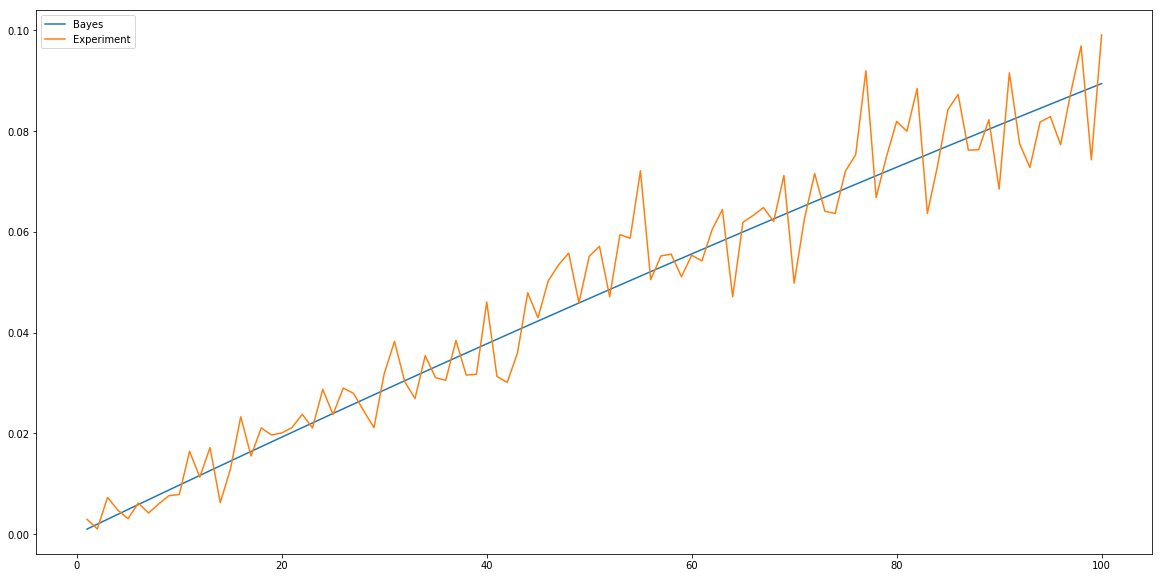

In [298]:
import pickle

def save_results(filename, *data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
save_results(f'pop_size={population_size}', *simulation())

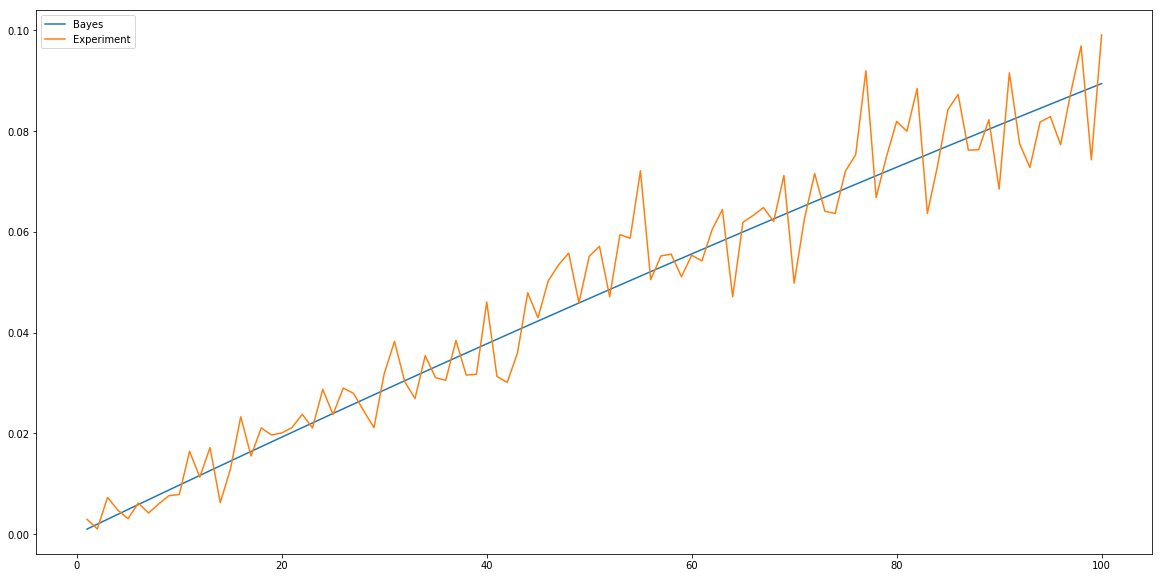

In [299]:
def plot_from_file(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        plotter(*data)

plot_from_file('pop_size=50000')